# DECOD Models

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)

from ML.model_training import (
    train_lstm,
    build_decod_lstm_sequences,
)
from ML import utils
import sys
import random
from itertools import product

# Data prep functions
def load_eego_df(
    filename: str | Path = "EEGo_labeled.csv",
) -> pd.DataFrame:
    """
    Load EEGo_labeled.csv and do minimal cleaning.
    """
    df = pd.read_csv(filename)

    # Sort by (user, session, time)
    sort_cols = ["user_id", "session_id"]
    if "time_elapsed" in df.columns:
        sort_cols.append("time_elapsed")
    elif "timestamp" in df.columns:
        sort_cols.append("timestamp")

    df = df.sort_values(sort_cols).reset_index(drop=True)
    return df

def select_eego_features(df: pd.DataFrame) -> list[str]:
    eeg_prefixes = [
        "AF3_", "F7_", "F3_", "FC5_", "T7_", "P7_",
        "O1_", "O2_", "P8_", "T8_", "FC6_", "F4_", "F8_", "AF4_",
    ]
    
    eeg_features = [
        c
        for c in df.columns
        if any(c.startswith(p) for p in eeg_prefixes)
    ]

    feature_cols = eeg_features
    return feature_cols

def balance_binary_sequences(
    X: np.ndarray, y: np.ndarray, seed: int = 5
) -> tuple[np.ndarray, np.ndarray]:
    """
    Downsample the majority class at the *sequence* level
    so that classes 0 and 1 are balanced.
    """
    rng = np.random.default_rng(seed)

    idx_pos = np.where(y == 1.0)[0]
    idx_neg = np.where(y == 0.0)[0]

    n_pos = len(idx_pos)
    n_neg = len(idx_neg)

    if n_pos == 0 or n_neg == 0 or n_pos == n_neg:
        return X, y

    if n_pos > n_neg:
        keep_pos = rng.choice(idx_pos, size=n_neg, replace=False)
        keep_idx = np.concatenate([keep_pos, idx_neg])
    else:
        keep_neg = rng.choice(idx_neg, size=n_pos, replace=False)
        keep_idx = np.concatenate([keep_neg, idx_pos])

    keep_idx = np.sort(keep_idx)
    return X[keep_idx], y[keep_idx]

Setup the DECOD dataset with features and identify and organize sessions.
Create a feature table using eegproc.

In [4]:
# Load data
df_eego = load_eego_df("DECOD/DECOD.csv")
print("DECOD shape:", df_eego.shape)

TEXT_VERSION = "text_version"
AROUSAL = "arousal"

df_eego[AROUSAL] = np.nan

df_eego.loc[df_eego[TEXT_VERSION] > 20, AROUSAL] = 1
df_eego.loc[
    (df_eego[TEXT_VERSION] > 10) & (df_eego[TEXT_VERSION] <= 20),
    AROUSAL
] = 0

df_eego = df_eego[df_eego[AROUSAL].isin([0, 1])].copy()
print("Binary df shape:", df_eego.shape)
counts = df_eego[AROUSAL].value_counts()

print(counts)
print(counts[1]/(counts[1]+counts[0]))

DECOD shape: (14250, 81)
Binary df shape: (9227, 81)
arousal
0.0    5231
1.0    3996
Name: count, dtype: int64
0.4330768397095481


In [ ]:
import eegproc as eeg

features_table: pd.DataFrame = pd.DataFrame()
freqs = {
    # "delta": (0.5, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 13.0),
    "betaL": (13.0, 20.0),
    "betaH": (20.0, 30.0),
    "gamma": (30.0, 45.0),
}
ch_names = [
    "AF3",
    "F7",
    "F3",
    "FC5",
    "T7",
    "P7",
    "O1",
    "O2",
    "P8",
    "T8",
    "FC6",
    "F4",
    "F8",
    "AF4",
]
meta_cols = [
    "user_id",
    "session_id",
    "start_stamp",
    "end_stamp",
    "eye_id",
    "text_version",
    "seen_words",
    "arousal",
    "valence",
    "sensor_contact_quality",
    "timestamp",
]

FS = 128

# --- only keep sessions WITHOUT text_version in [15, 16] ---
EXCLUDED_TEXT_VERSIONS = [15, 16]

valid_sessions = [
    sid
    for sid, g in df_eego.groupby("session_id")
    if not g["text_version"].isin(EXCLUDED_TEXT_VERSIONS).any()
]

print("Number of valid sessions (excluding text_version 15/16):", len(valid_sessions))
print(valid_sessions)

for session in valid_sessions:
    mask = df_eego["session_id"] == session
    eeg_df = df_eego.loc[mask, :].copy()

    if eeg_df.empty:
        continue

    session_id = eeg_df["session_id"]
    end_stamp = eeg_df["end_stamp"]
    arousal = eeg_df[AROUSAL]

    eeg_df = eeg_df.drop(
        columns=meta_cols,
        errors="ignore",
    )

    shannons = eeg.shannons_entropy(eeg_df, bands=freqs)
    da = utils.compute_asymmetry_from_psd(eeg_df)

    batch = pd.concat([session_id, end_stamp, arousal, eeg_df, shannons, da], axis=1)

    features_table = pd.concat([features_table, batch], ignore_index=True)

features_table = features_table.sort_values(
    by=["session_id", "end_stamp"],
    ascending=True
)
features_table.to_csv("datasets/decod_features.csv", index=False)
features_table = pd.read_csv("datasets/decod_features.csv")


feature_cols = select_eego_features(features_table)
print("n_features:", len(feature_cols))
print(feature_cols)

session_ids = features_table["session_id"].unique().tolist()
print("Number of sessions:", len(session_ids))
print(session_ids)


Number of valid sessions (excluding text_version 15/16): 11
['2637835c-3782-4e6d-9920-1c0126e785f3', '3bea4e63-e6ac-4000-bd62-1b69c0a3b6a5', '3d5b14ed-b668-46c5-9a60-0b7af63f9658', '56c06616-46ed-4076-b184-895ca1d44207', '6981c2cf-d7e3-414a-bf4b-aba1b33fcc5e', '6b38fd78-439c-481f-88fd-2198f11a8c78', '7731616d-54c3-45dc-abc3-b67908893710', 'b192fe37-1e4d-4cf0-8ed8-29ea2ea0b1cd', 'cf2e7ce6-2d76-4ba9-bbf5-93a0d45cc4f0', 'e2c5e9f4-e432-4ce1-b7a7-9158f3bf6b7a', 'f50c52f0-1d87-4ab7-974b-0ed1d00dc217']
n_features: 126
['AF3_theta', 'AF3_alpha', 'AF3_betaL', 'AF3_betaH', 'AF3_gamma', 'F7_theta', 'F7_alpha', 'F7_betaL', 'F7_betaH', 'F7_gamma', 'F3_theta', 'F3_alpha', 'F3_betaL', 'F3_betaH', 'F3_gamma', 'FC5_theta', 'FC5_alpha', 'FC5_betaL', 'FC5_betaH', 'FC5_gamma', 'T7_theta', 'T7_alpha', 'T7_betaL', 'T7_betaH', 'T7_gamma', 'P7_theta', 'P7_alpha', 'P7_betaL', 'P7_betaH', 'P7_gamma', 'O1_theta', 'O1_alpha', 'O1_betaL', 'O1_betaH', 'O1_gamma', 'O2_theta', 'O2_alpha', 'O2_betaL', 'O2_betaH', 'O2_

## LSTM LOO Optimizer

Performs Leave-One-Out (omit one session) cross-validation, where each **session_id**
is held-out as the test fold once. We search over a small hyperparameter grid.

In [17]:
# Hyper-parameter grid for global EEGo LSTM
THRESH = 0.5
param_grid = {
    "lr": [0.0001],
    "epochs": [30],
    "units": [256],
    "batch_size": [128],
    "patience": [200],
}


# sessions = []
# for i in range(1):
#     while True:
#         r = random.randint(0, len(session_ids) - 1)
#         if session_ids[r] not in sessions:
#             sessions.append(session_ids[r])
#             break

best_params = None
best_mean_acc = -np.inf

cm_full = [[0, 0], [0, 0]]

print("Starting EEGo LOO hyperparameter search over sessions...\n")


for lr, epochs, units, batch_size, patience in product(
    param_grid["lr"],
    param_grid["epochs"],
    param_grid["units"],
    param_grid["batch_size"],
    param_grid["patience"],
):
    combo_accs = []

    for sid in session_ids:
        # Leave session out
        print("LEFT OUT:", sid)
        train_df = features_table[features_table["session_id"] != sid].reset_index(
            drop=True
        )
        test_df = features_table[features_table["session_id"] == sid].reset_index(
            drop=True
        )

        print(train_df[AROUSAL].value_counts())
        print(test_df[AROUSAL].value_counts())
        # Build sequence for lstm
        X_train_seq, y_train_seq = build_decod_lstm_sequences(
            train_df,
            feature_cols=feature_cols,
            target_col=AROUSAL,
            thresh=THRESH,
            fixed_T=700,
        )
        X_test_seq, y_test_seq = build_decod_lstm_sequences(
            test_df,
            feature_cols=feature_cols,
            target_col=AROUSAL,
            thresh=THRESH,
            fixed_T=700,
        )
        print(X_train_seq.shape)


        X_train_seq, y_train_seq = balance_binary_sequences(X_train_seq, y_train_seq)
        # X_test_seq, y_test_seq = balance_binary_sequences(X_test_seq, y_test_seq)
        lstm_model, X_test_eval, y_test_eval = train_lstm(
            X_train_seq,
            X_test_seq,
            y_train_seq,
            y_test_seq,
            lr=lr,
            epochs=epochs,
            units=units,
            batch_size=batch_size,
            patience=patience,
            bidirectional=True,
        )

        y_pred_prob = lstm_model.predict(X_test_eval).ravel()
        y_pred = (y_pred_prob <= 0.5).astype("int32")
        y_true = y_test_eval.astype("int32")

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        cm_full += cm

        print(acc)
        print(cm)
        combo_accs.append(acc)

    mean_acc = float(np.mean(combo_accs))
    std_acc = float(np.std(combo_accs))

    print(
        f"lr={lr}, epochs={epochs}, units={units}, batch={batch_size}, "
        f" -> mean acc={mean_acc:.4f} (std={std_acc:.4f})"
    )

    if mean_acc > best_mean_acc:
        best_mean_acc = mean_acc
        best_params = {
            "lr": lr,
            "epochs": epochs,
            "units": units,
            "batch_size": batch_size,
            "patience": patience,
        }

print("\nBest DECOD LOO mean test accuracy:", f"{best_mean_acc:.4f}")
print("Best params:", best_params)

Starting EEGo LOO hyperparameter search over sessions...

LEFT OUT: 2637835c-3782-4e6d-9920-1c0126e785f3
arousal
1.0    3996
0.0    2728
Name: count, dtype: int64
arousal
0.0    289
Name: count, dtype: int64
(10, 700, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1.0
[[1 0]
 [0 0]]
LEFT OUT: 3bea4e63-e6ac-4000-bd62-1b69c0a3b6a5
arousal
1.0    3355
0.0    3017
Name: count, dtype: int64
arousal
1.0    641
Name: count, dtype: int64
(10, 700, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1.0
[[0 0]
 [0 1]]
LEFT OUT: 3d5b14ed-b668-46c5-9a60-0b7af63f9658
arousal
1.0    3336
0.0    3017
Name: count, dtype: int64
arousal
1.0    660
Name: count, dtype: int64
(10, 700, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
0.0
[[0 0]
 [1 0]]
LEFT OUT: 56c06616-46ed-4076-b184-895ca1d44207
arousal
1.0    3420
0.0    3017
Name: count, dtype: int64
arousal
1.0    576
Name: count, dtype: int64
(10, 700, 126)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1.0
[[0 0]
 [0 1]]
LEFT OUT: 6981c2cf-d7e3-414a-bf4b-aba1b33fcc5e
aro

[[3 2]
 [2 4]]


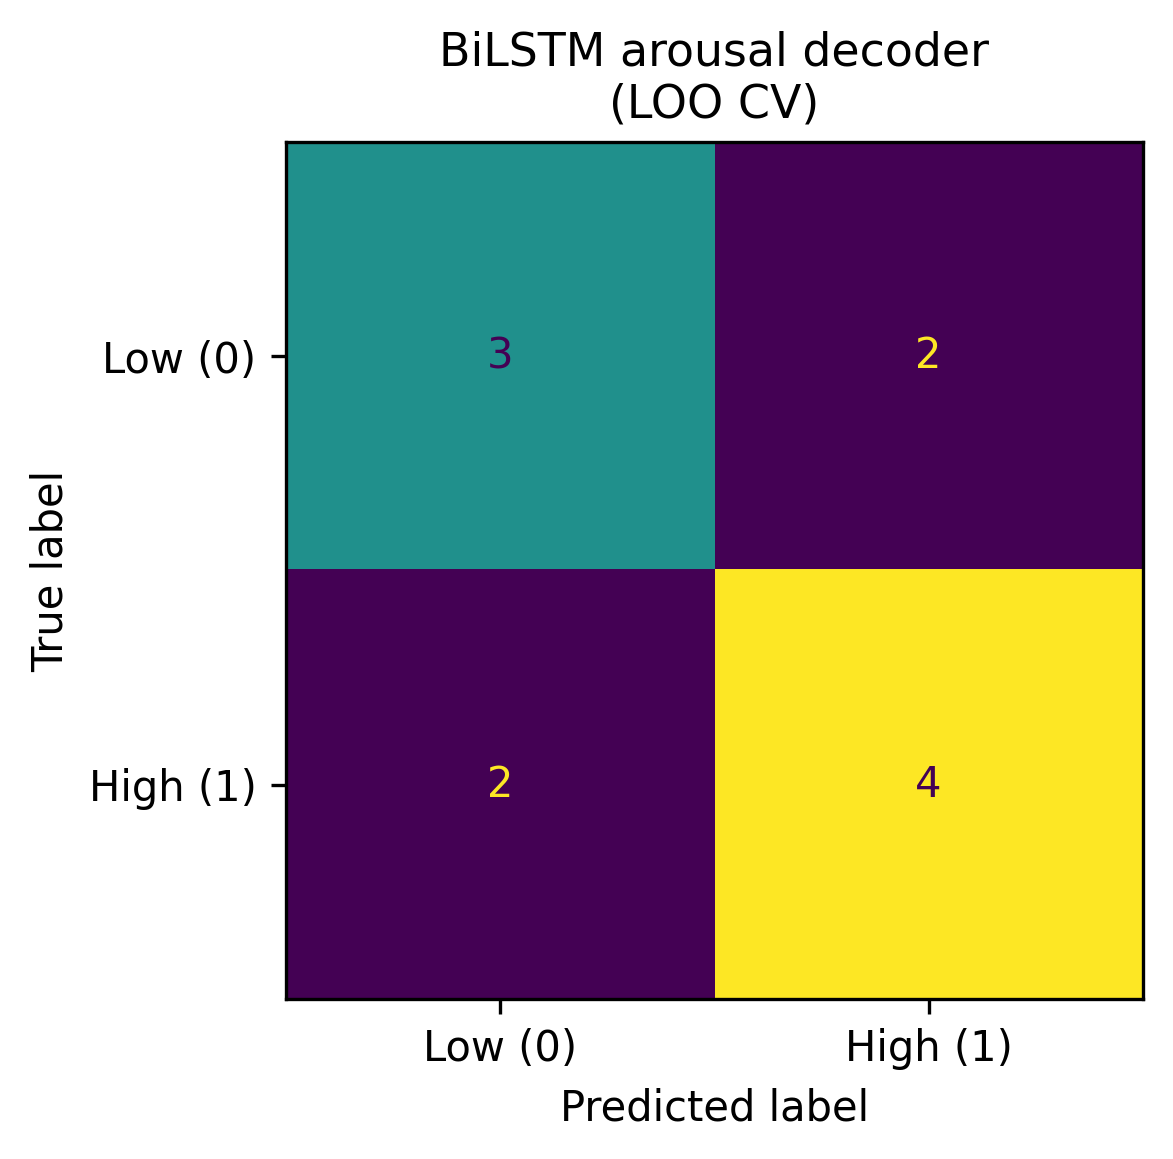

Confusion matrix:
[[3 2]
 [2 4]]
Accuracy:  0.636
Precision (class 1): 0.667
Recall (class 1):    0.667
F1-score (class 1):  0.667


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Aggregated confusion matrix from your LOO runs
# Rows = true labels, Columns = predicted labels
# [[TN, FP],
#  [FN, TP]]
print(cm_full)

class_names = ["Low (0)", "High (1)"]

# --- Plot confusion matrix ---
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)  # high-res for publication

disp = ConfusionMatrixDisplay(confusion_matrix=cm_full,
                              display_labels=class_names)

disp.plot(values_format="d", ax=ax, colorbar=False)

ax.set_xlabel("Predicted label", fontsize=10)
ax.set_ylabel("True label", fontsize=10)
ax.set_title("BiLSTM arousal decoder\n(LOO CV)", fontsize=11)

plt.tight_layout()
plt.show()

# --- Compute and print basic metrics ---
tn, fp, fn, tp = cm_full.ravel()

accuracy = (tp + tn) / cm_full.sum()
precision_1 = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else float("nan")
f1_1 = (2 * precision_1 * recall_1 / (precision_1 + recall_1)
        if precision_1 + recall_1 > 0 else float("nan"))

print(f"Confusion matrix:\n{cm_full}")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision (class 1): {precision_1:.3f}")
print(f"Recall (class 1):    {recall_1:.3f}")
print(f"F1-score (class 1):  {f1_1:.3f}")
